# Preprocessing

In [23]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)

import sys
sys.path.insert(0, "../02_src")

In [24]:
merged_df = pd.read_csv("../00_data/1_interim/merged_data.csv")

### Handle High Missing Values #1: by Code (Country ID)

In [25]:
# Missing Values by Country ID (Code)
all_missing_values = merged_df.isnull().groupby(merged_df["Entity"]).sum()
# 9 main potential features: 
values_count_per_country = merged_df.groupby(merged_df["Entity"]).size().iloc[0] * 9

all_missing_values["total_missing"] = all_missing_values.sum(axis=1)
all_missing_values["total_missing_%"] = round( ( all_missing_values["total_missing"] / values_count_per_country ) * 100, 2)
#plot top 12 countries with most missing values
top_missing_countries = all_missing_values.sort_values(ascending=False, by="total_missing")
top_12_missing = top_missing_countries["total_missing"].head(12)
print(f"Top 12 Countries with most missing values:\n{top_12_missing}")
#Threshold 50%: all countries with missing values over 50% get excluded from Dataframe
# 9 x 6 = 54 data point for each country --> 27 NaNs as upper limit: 
# AIA       49 (Anguilla)
# MSR       48 (Montserrat)
# OWID_KOS  48 (Kosovo)
# COK       42 (Cook Islands)
# NIU       42 (Niue)
# TCA       39 (Turks and Caicos Islands)
# VGB       38 (British Virgin Islands)

Top 12 Countries with most missing values:
Entity
Anguilla                    49
Montserrat                  48
Kosovo                      48
Niue                        42
Cook Islands                42
Turks and Caicos Islands    39
British Virgin Islands      38
North Korea                 26
South Sudan                 26
Monaco                      25
Equatorial Guinea           22
Venezuela                   21
Name: total_missing, dtype: int64


In [26]:
# Exclude high missing values countries (threshold >= 50%) & save as new df
# new filtered version has now 967 missing values (306 less than before)
exclude_countries = top_missing_countries[top_missing_countries["total_missing_%"] >= 50]
filtered_df = merged_df[~merged_df["Entity"].isin(exclude_countries.index.tolist())].copy()
filtered_df.to_csv('../00_data/1_interim/filtered_data_01.csv', index=False)
filtered_df.isna().sum().sum()

967

In [27]:
filtered_df.isna().sum()

Code                                          0
Year                                          0
Entity                                        0
child_mortality_igme                          0
annual_healthcare_expenditure_per_capita     16
gdp_per_capita_worldbank                     42
nurses_and_midwives_per_1000_people         300
physicians_per_1000_people                  405
prevalence_of_undernourishment              156
share_of_population_urban                     0
share_without_improved_water                 16
vaccination_coverage_who_unicef               6
years_of_schooling                           26
dtype: int64

### Testing: Missing Indikators

In [28]:
# add _missing indikator: 0 if not missing, 1 if missing

example_train_set = pd.read_csv('../00_data/2_split/train_df_raw.csv', index_col=0)
missing_indicators_df = example_train_set.copy()

for column in missing_indicators_df.columns:
    if missing_indicators_df[column].isna().sum() > 0:
        missing_indicators_df[column+"_missing"] = missing_indicators_df[column].isna().astype(int)

In [29]:
missing_indicators_df.head()

,Code,Year,Entity,child_mortality_igme,annual_healthcare_expenditure_per_capita,gdp_per_capita_worldbank,nurses_and_midwives_per_1000_people,physicians_per_1000_people,prevalence_of_undernourishment,share_of_population_urban,...,vaccination_coverage_who_unicef,years_of_schooling,annual_healthcare_expenditure_per_capita_missing,gdp_per_capita_worldbank_missing,nurses_and_midwives_per_1000_people_missing,physicians_per_1000_people_missing,prevalence_of_undernourishment_missing,share_without_improved_water_missing,vaccination_coverage_who_unicef_missing,years_of_schooling_missing
0,AFG,2013,Afghanistan,78.022990,177.62009,3046.5798,0.255,0.291,19.4,24.373,...,64.0,0.672197,0,0,0,0,0,0,0,0
1,AFG,2014,Afghanistan,75.123625,201.79086,3017.9426,0.151,0.304,19.3,24.587,...,62.0,0.710609,0,0,0,0,0,0,0,0
2,AFG,2015,Afghanistan,72.438707,215.22618,2967.6921,0.133,0.291,20.0,24.803,...,64.0,0.749020,0,0,0,0,0,0,0,0
3,AFG,2016,Afghanistan,69.970040,238.74481,2958.7854,0.151,0.284,20.5,25.020,...,66.0,1.009183,0,0,0,0,0,0,0,0
4,AFG,2017,Afghanistan,67.637370,264.20660,2952.9990,0.179,0.245,21.4,25.250,...,64.0,1.269347,0,0,0,0,0,0,0,0


### Test Imputation (for whole df)

In [30]:
df_for_imp = pd.read_csv("../00_data/1_interim/mar_test_data.csv")
df_for_imp

wb_regions = pd.get_dummies(df_for_imp["World regions according to WB"], dtype="int64") #create dummies from WB regions
df_imp_test = pd.concat([df_for_imp, wb_regions], axis=1).drop(columns=["World regions according to WB"])

df_imp_test_full = pd.concat([df_for_imp, wb_regions], axis=1)

#df_imp_test = df_imp_test.drop(columns=["Year", "Entity", "child_mortality_igme"], axis=1)
df_imp_test = df_imp_test.drop(columns=["Code", "Year", "Entity", "child_mortality_igme"], axis=1)

In [31]:
# Calculate metrics of new imputed dfs for comparison
def calculate_metrics(original_df, imputed_df, cols):
    # Varianz
    variance_diff = ((imputed_df[cols].var() - original_df[cols].var()) / original_df[cols].var()) * 100
  
    print (f"Variance Differences in %:\n{round(variance_diff, 2)}")

#### Test 1: descriptive Imputation - Mean, Median

In [32]:
import data_exploration #visualizations

def nan_indicators(df):
    missing_indicators = df.columns.str.contains("_missing", regex=False)
    return missing_indicators

def wb_regions(df):
    regions = df.columns.str.contains("WB", regex=False)
    return regions

cols_with_nans = df_for_imp.columns[df_for_imp.isna().any()].tolist()
most_critical_cols = ["physicians_per_1000_people", "nurses_and_midwives_per_1000_people", "prevalence_of_undernourishment"]
label_col = df_for_imp[["child_mortality_igme"]]

##### Mean

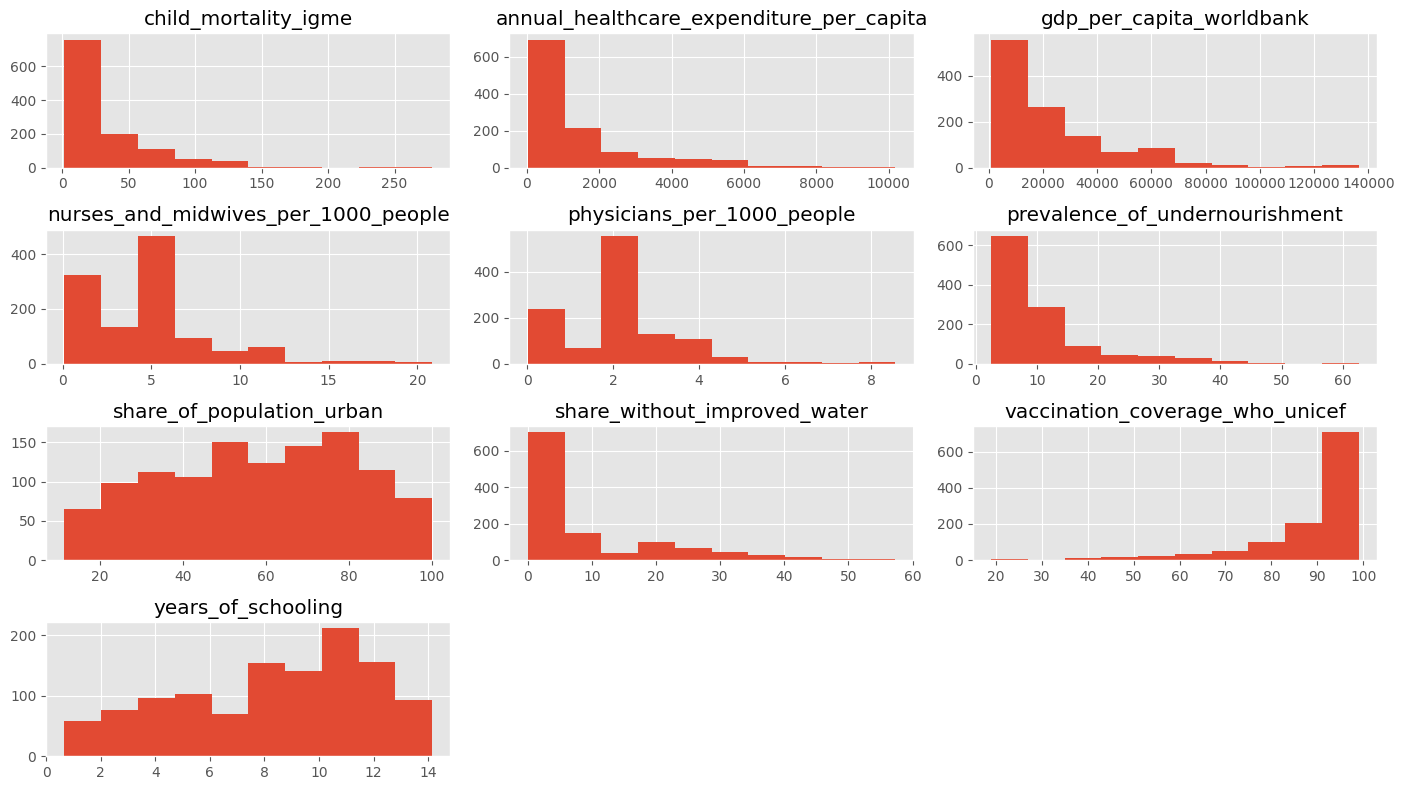

Variance Differences in %:
annual_healthcare_expenditure_per_capita    -1.38
gdp_per_capita_worldbank                    -3.63
nurses_and_midwives_per_1000_people        -25.93
physicians_per_1000_people                 -35.00
prevalence_of_undernourishment             -13.48
share_without_improved_water                -1.38
vaccination_coverage_who_unicef             -0.52
years_of_schooling                          -2.25
dtype: float64


In [33]:
imputed_with_mean = df_imp_test.copy()

imputed_with_mean = imputed_with_mean.fillna(imputed_with_mean.mean())
mean_df = imputed_with_mean.loc[:, ~nan_indicators(imputed_with_mean) & ~wb_regions(imputed_with_mean)]

mean_df = pd.concat([label_col, mean_df], axis=1)

#show histograms
data_exploration.histograms(mean_df)
calculate_metrics(df_imp_test, mean_df, cols_with_nans)

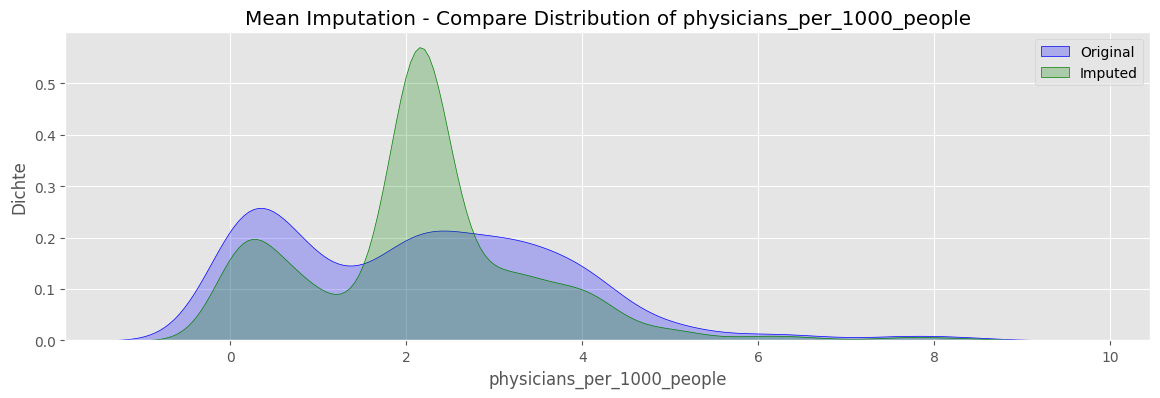

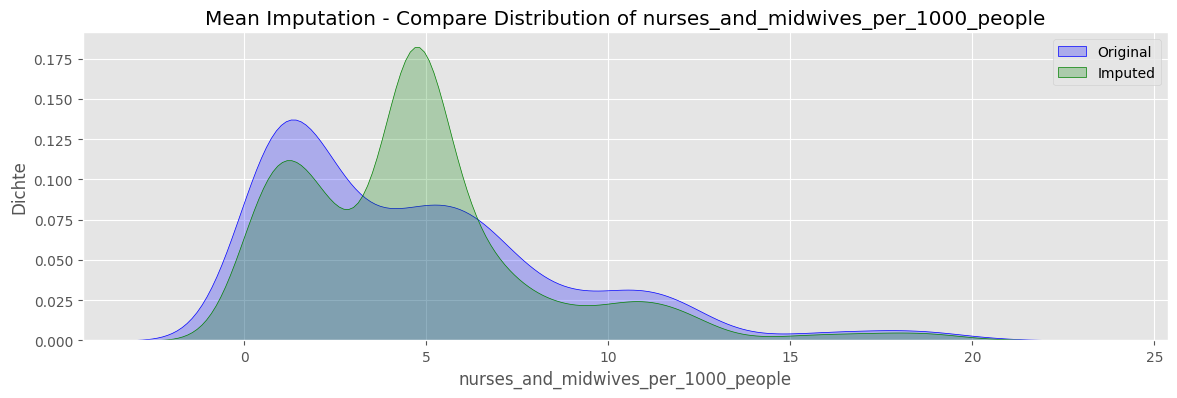

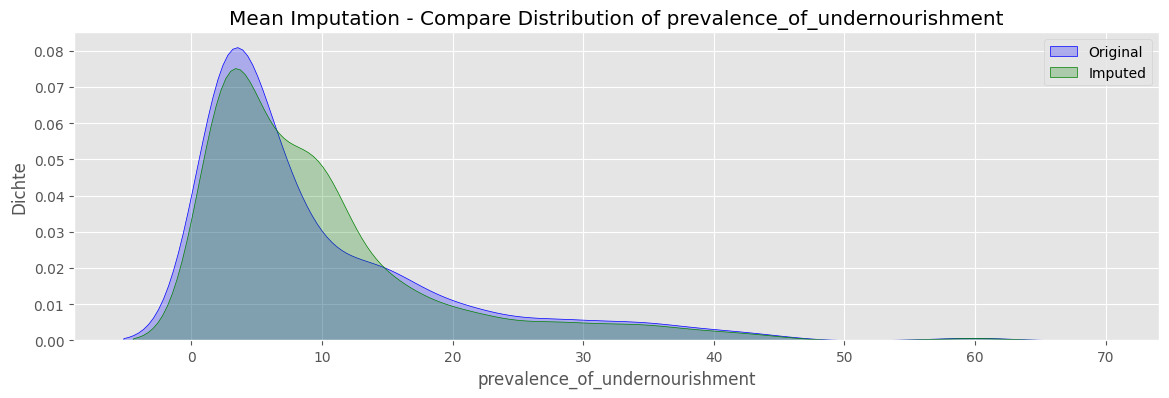

In [35]:
# KDE Plots - Compare Original Variable Distribution & Imputed Variable Distribution
def kde_plot_comparison(original_df, imputed_df, variable, imp_type):
    plt.figure(figsize=(14,4))
    sns.kdeplot(original_df.loc[~original_df[variable].isna(), variable], color='blue', fill=True)
    sns.kdeplot(imputed_df[variable], color='green', fill=True)
    #plt.axvline(x=original_df[variable].mean(), color='red', linestyle='-')
    plt.title(f"{imp_type} - Compare Distribution of {variable}")
    plt.ylabel('Dichte')
    plt.legend(["Original", "Imputed"])
    plt.show()

# Plot for the 3 variables with most nans
kde_plot_comparison(df_imp_test, mean_df, "physicians_per_1000_people", "Mean Imputation")
kde_plot_comparison(df_imp_test, mean_df, "nurses_and_midwives_per_1000_people", "Mean Imputation")
kde_plot_comparison(df_imp_test, mean_df, "prevalence_of_undernourishment", "Mean Imputation")

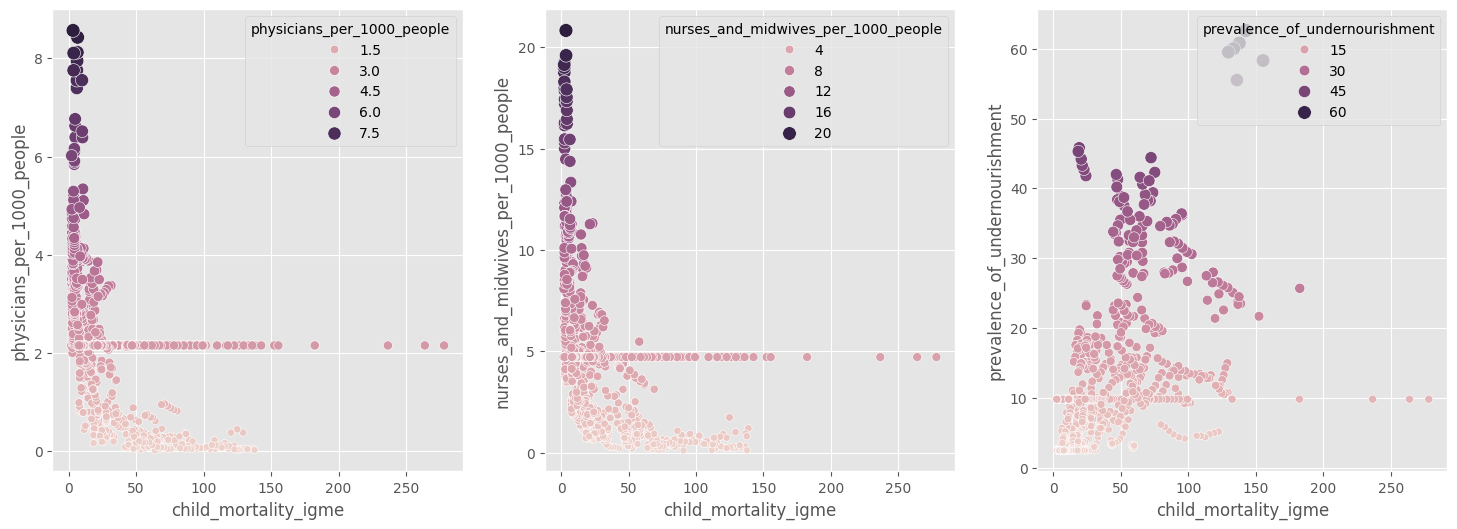

In [36]:
data_exploration.scatterplots(mean_df, most_critical_cols, 3)

##### Median

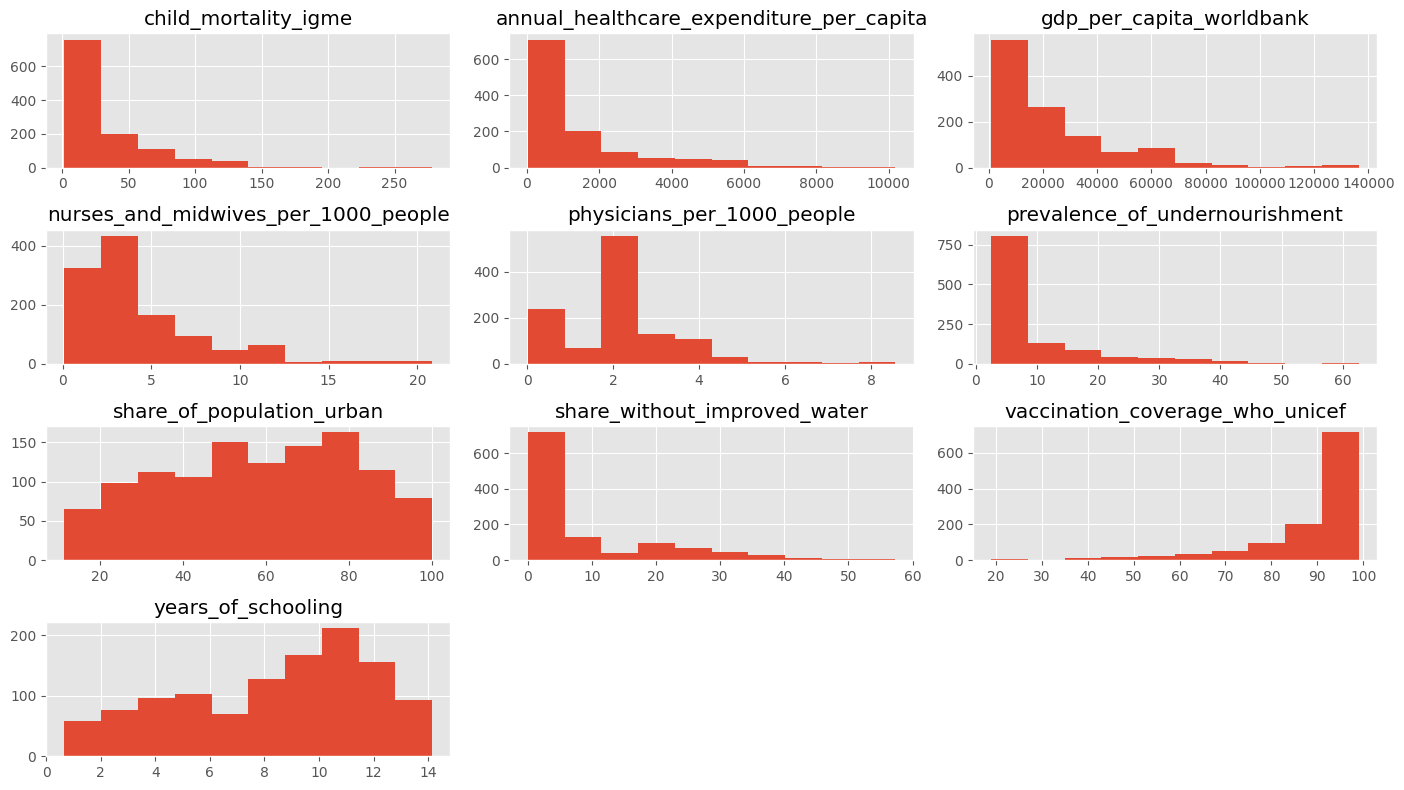

Variance Differences in %:
annual_healthcare_expenditure_per_capita    -1.16
gdp_per_capita_worldbank                    -3.20
nurses_and_midwives_per_1000_people        -25.08
physicians_per_1000_people                 -35.00
prevalence_of_undernourishment             -11.71
share_without_improved_water                -1.06
vaccination_coverage_who_unicef             -0.45
years_of_schooling                          -2.17
dtype: float64


In [37]:
imputed_with_median = df_imp_test.copy()
imputed_with_median = imputed_with_median.fillna(imputed_with_median.median())
median_df = imputed_with_median.loc[:, ~nan_indicators(imputed_with_median) & ~wb_regions(imputed_with_median)]

median_df = pd.concat([label_col, median_df], axis=1)

#show histograms
data_exploration.histograms(median_df)
calculate_metrics(df_imp_test, median_df, cols_with_nans)

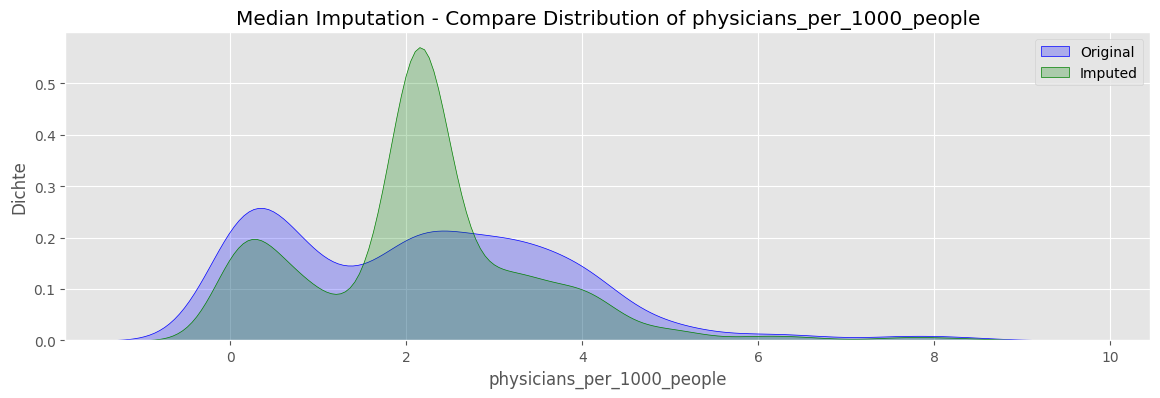

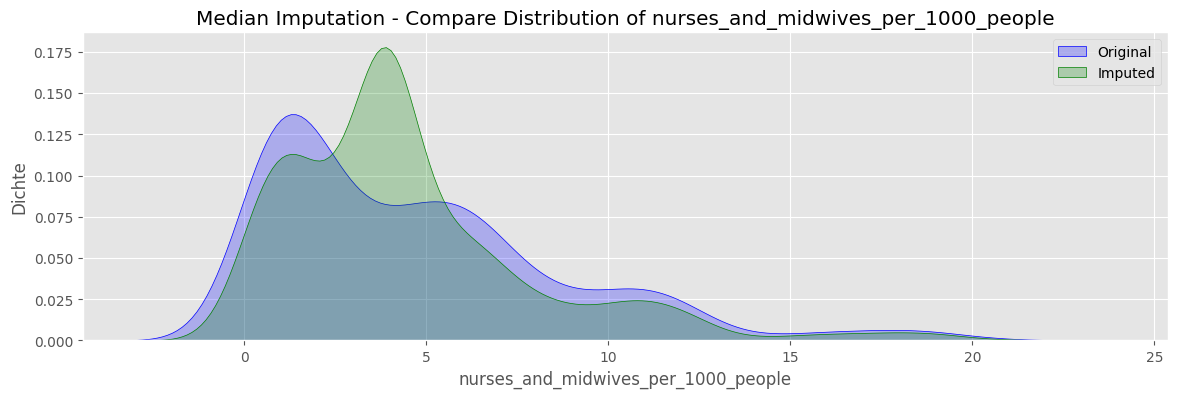

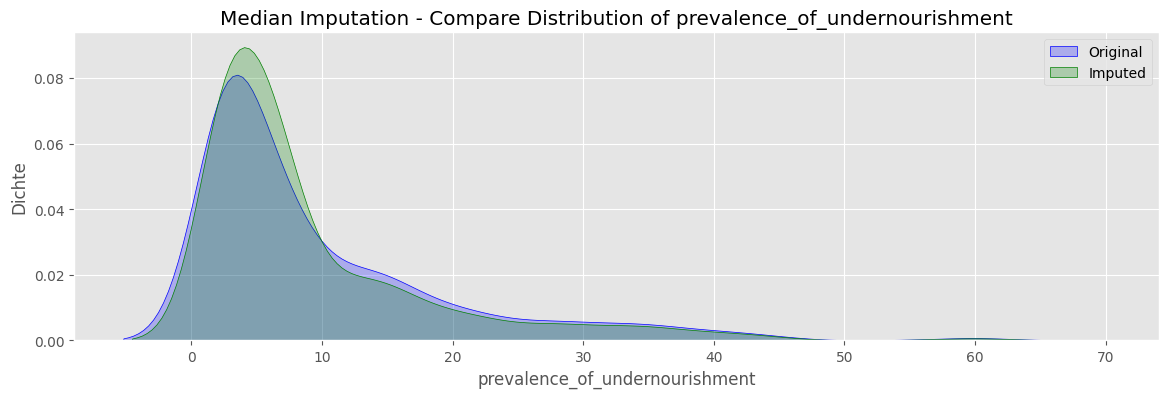

In [38]:
# KDE Plots for the 3 variables with most nans
kde_plot_comparison(df_imp_test, median_df, "physicians_per_1000_people", "Median Imputation")
kde_plot_comparison(df_imp_test, median_df, "nurses_and_midwives_per_1000_people", "Median Imputation")
kde_plot_comparison(df_imp_test, median_df, "prevalence_of_undernourishment", "Median Imputation")

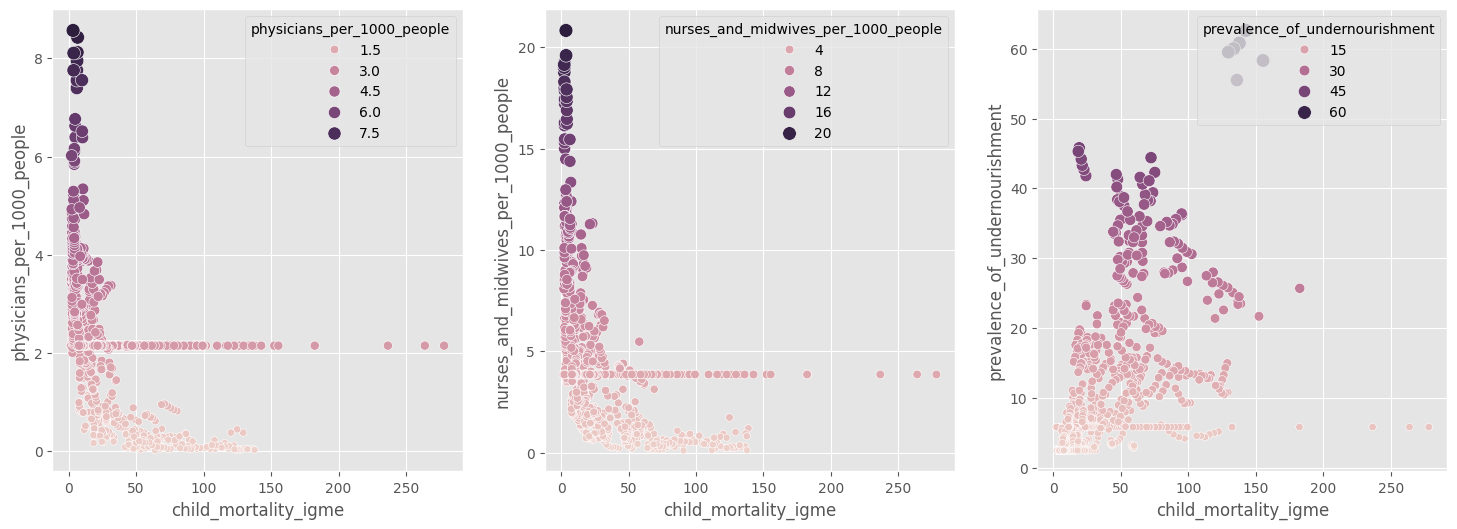

In [39]:
data_exploration.scatterplots(median_df, most_critical_cols, 3)

#### Test 2 - Median but country- & region-specific

##### Median Grouped by country or region

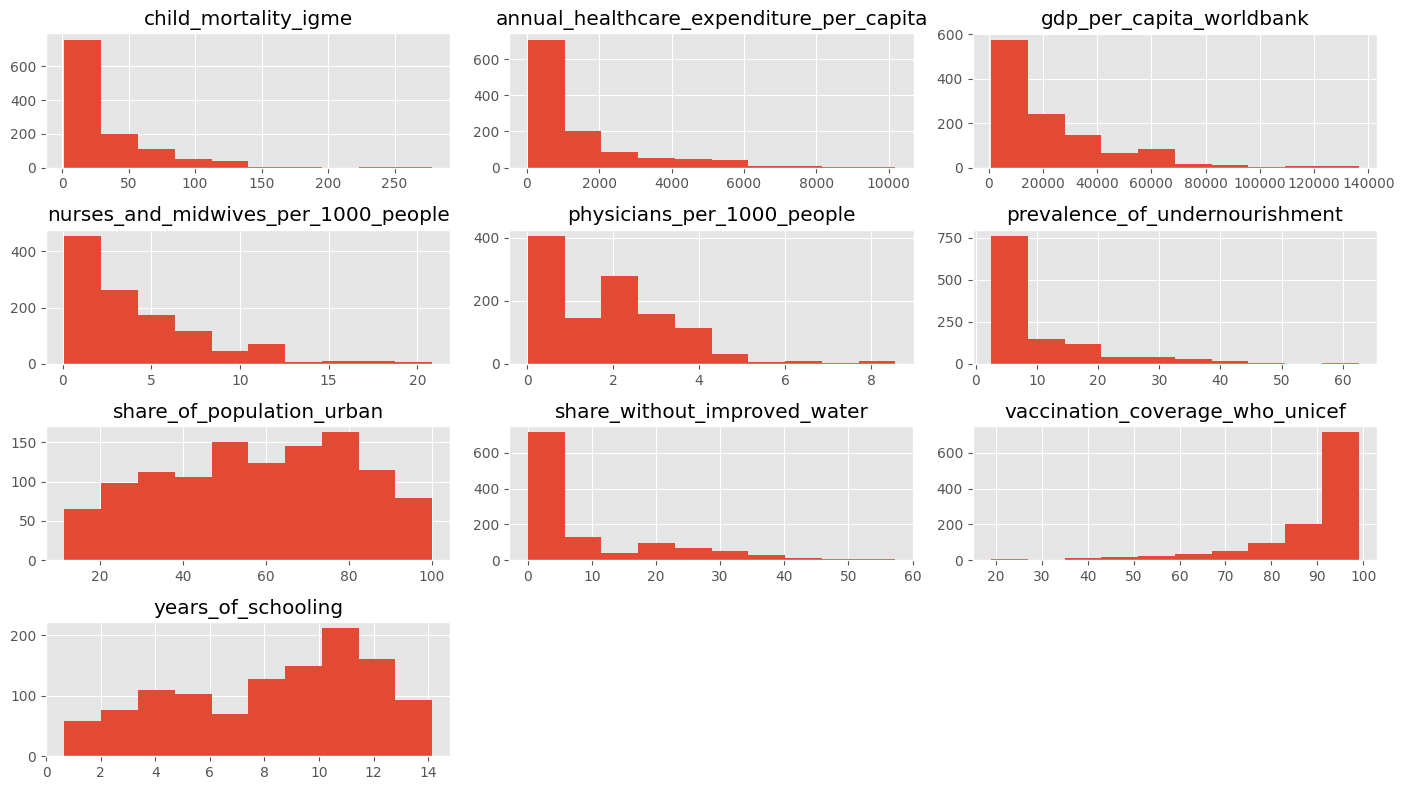

Variance Differences in %:
annual_healthcare_expenditure_per_capita    -0.98
gdp_per_capita_worldbank                    -2.51
nurses_and_midwives_per_1000_people        -13.35
physicians_per_1000_people                 -12.62
prevalence_of_undernourishment             -10.80
share_without_improved_water                 0.07
vaccination_coverage_who_unicef             -0.48
years_of_schooling                          -0.42
dtype: float64


In [56]:
# 
imputed_groupwise = df_imp_test_full.copy()
numeric_cols = imputed_groupwise.select_dtypes(include=["float64"]).columns.tolist()
rows_per_country = imputed_groupwise.groupby('Entity').size().iloc[0]

for numeric_col in numeric_cols:
    if imputed_groupwise[numeric_col].isna().sum() > 0:
        nans_by_country = imputed_groupwise.groupby("Entity")[numeric_col].transform(lambda x: x.isna().sum())

        # for less nans per Entity in a col, use median by Entity, otherwise median of WorldBank region 
        country_median = imputed_groupwise.groupby("Entity")[numeric_col].transform("median")
        region_median = imputed_groupwise.groupby("World regions according to WB")[numeric_col].transform("median")
        #global_median = imputed_groupwise[numeric_col].median()
        imputes = np.where(nans_by_country <= 3, country_median, region_median)

        imp_types = pd.Series(imputes, index=imputed_groupwise.index)
        imputed_groupwise[numeric_col] = imputed_groupwise[numeric_col].fillna(imp_types)

group_median_df = imputed_groupwise.loc[:, ~nan_indicators(imputed_groupwise) & ~wb_regions(imputed_groupwise)]
#show histograms
data_exploration.histograms(group_median_df.drop(columns=["Year"]))

#calculate metrics
calculate_metrics(df_imp_test, group_median_df, cols_with_nans)

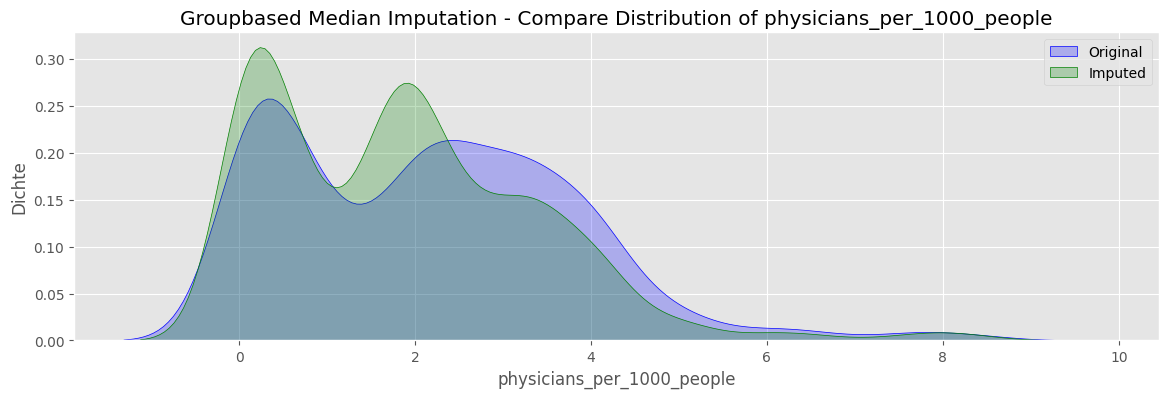

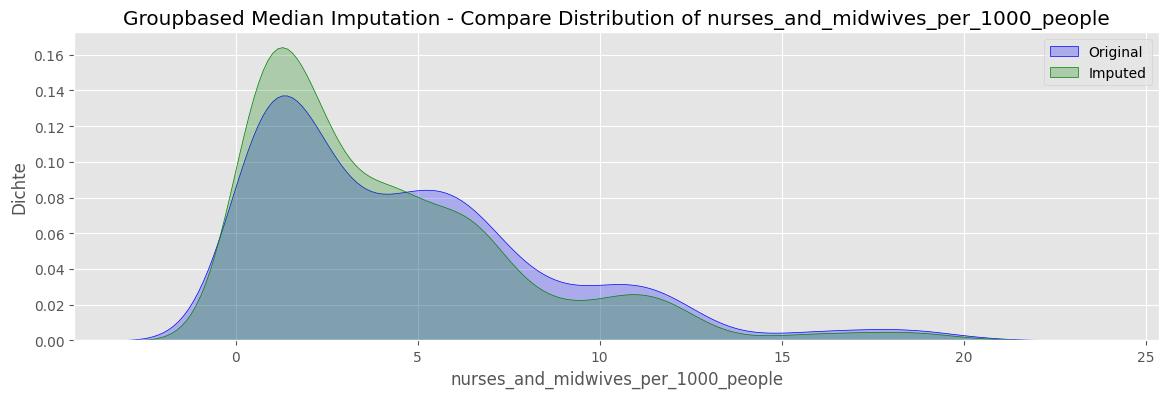

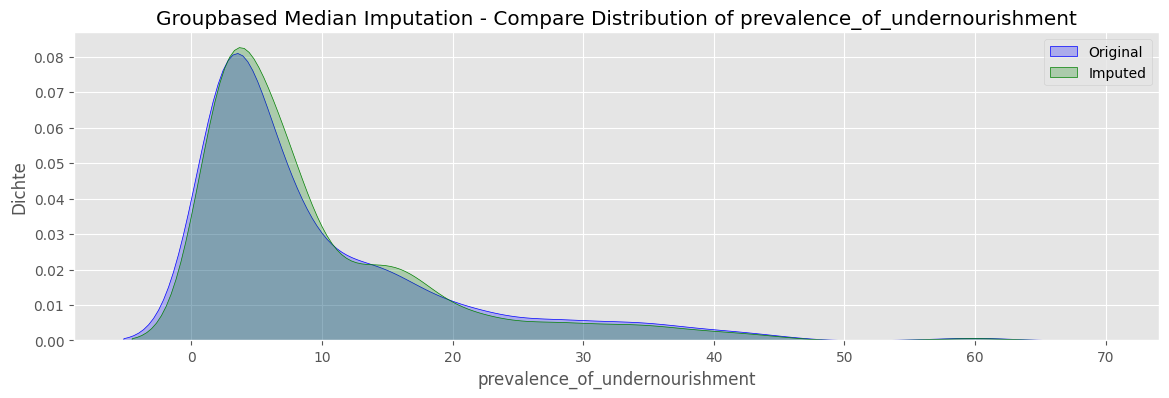

In [41]:
kde_plot_comparison(df_imp_test, group_median_df, "physicians_per_1000_people", "Groupbased Median Imputation")
kde_plot_comparison(df_imp_test, group_median_df, "nurses_and_midwives_per_1000_people", "Groupbased Median Imputation")
kde_plot_comparison(df_imp_test, group_median_df, "prevalence_of_undernourishment", "Groupbased Median Imputation")

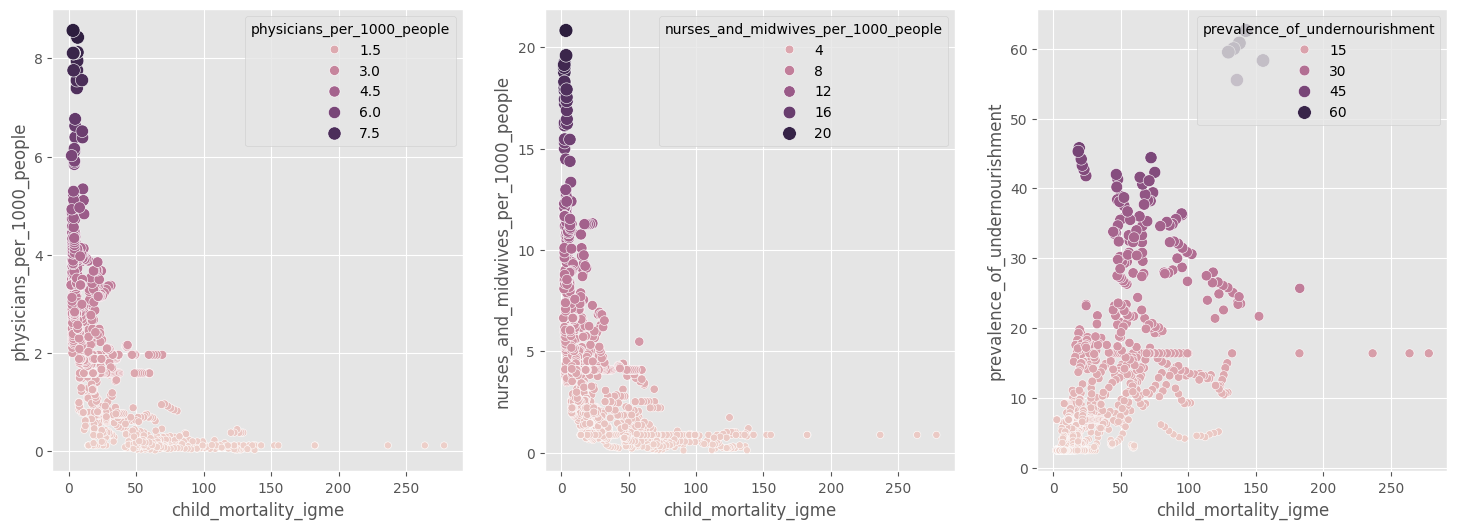

In [42]:
data_exploration.scatterplots(group_median_df, most_critical_cols, 3)

#### Test3 - KNN Imputer

In [87]:
# Impute with KNN - testwise scale data before (with RobustScaler)
from sklearn.preprocessing import RobustScaler 
from sklearn.impute import KNNImputer

imputed_with_knn = df_imp_test.copy()
rscaler = RobustScaler().fit(imputed_with_knn)
rscaled_data = rscaler.transform(imputed_with_knn)

imputer = KNNImputer(n_neighbors=5) #as base use k=5
knn_imputed_scaled = imputer.fit_transform(rscaled_data)
# reverse back to original value ranges
knn_imputed = rscaler.inverse_transform(knn_imputed_scaled)

df_knn_imputed = pd.DataFrame(knn_imputed, columns=imputed_with_knn.columns)

knn_df = df_knn_imputed.loc[:, ~nan_indicators(df_knn_imputed) & ~wb_regions(df_knn_imputed)]
knn_df = pd.concat([label_col, knn_df], axis=1) #add label to df

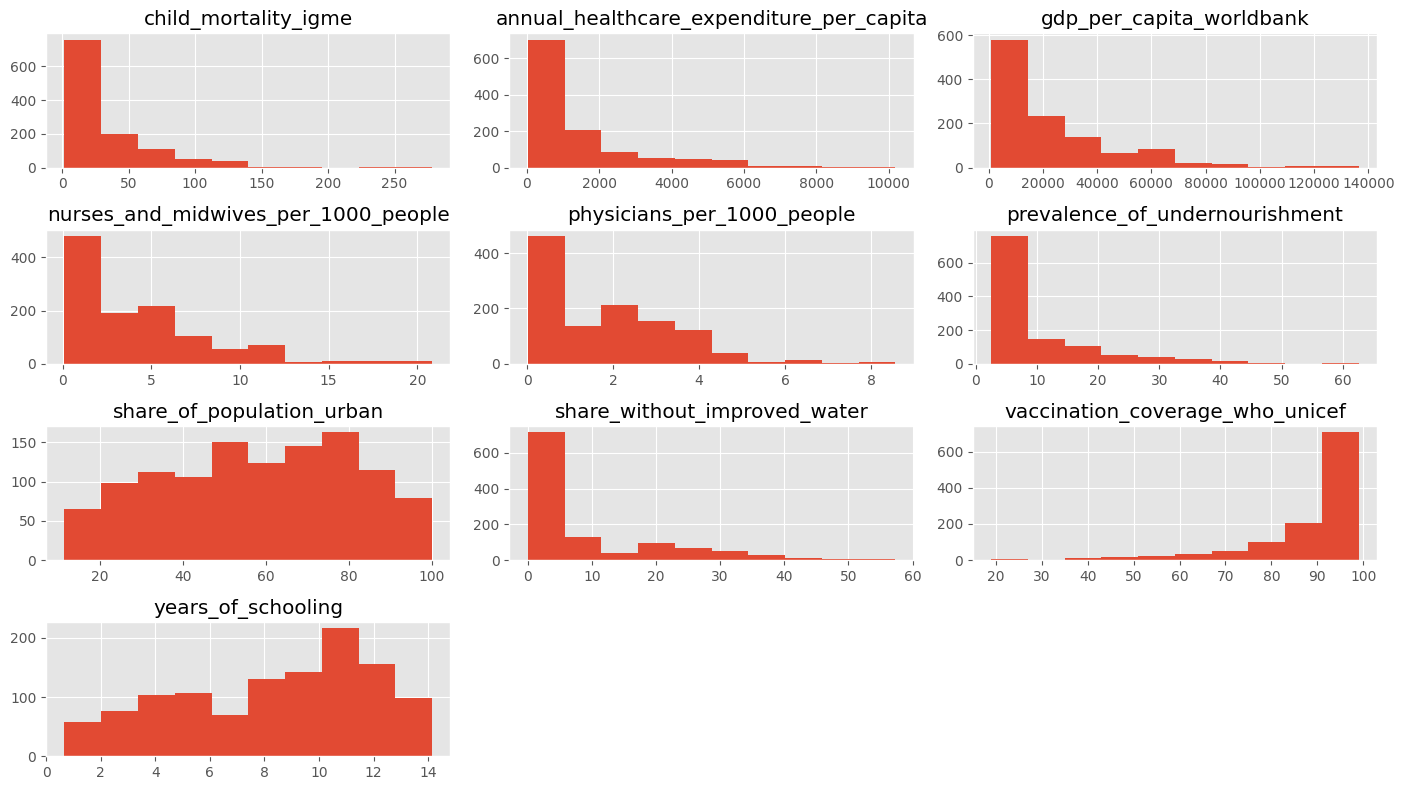

Variance Differences in %:
annual_healthcare_expenditure_per_capita   -1.11
gdp_per_capita_worldbank                    1.95
nurses_and_midwives_per_1000_people        -6.29
physicians_per_1000_people                 -9.08
prevalence_of_undernourishment             -6.69
share_without_improved_water               -0.10
vaccination_coverage_who_unicef            -0.51
years_of_schooling                          0.18
dtype: float64


In [88]:
#show histograms
data_exploration.histograms(knn_df)

#calculate metrics
calculate_metrics(df_imp_test, knn_df, cols_with_nans)

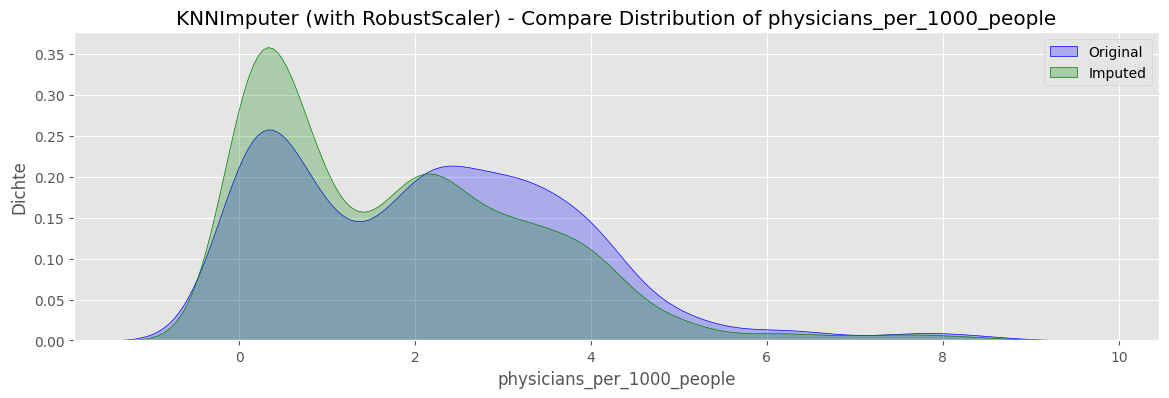

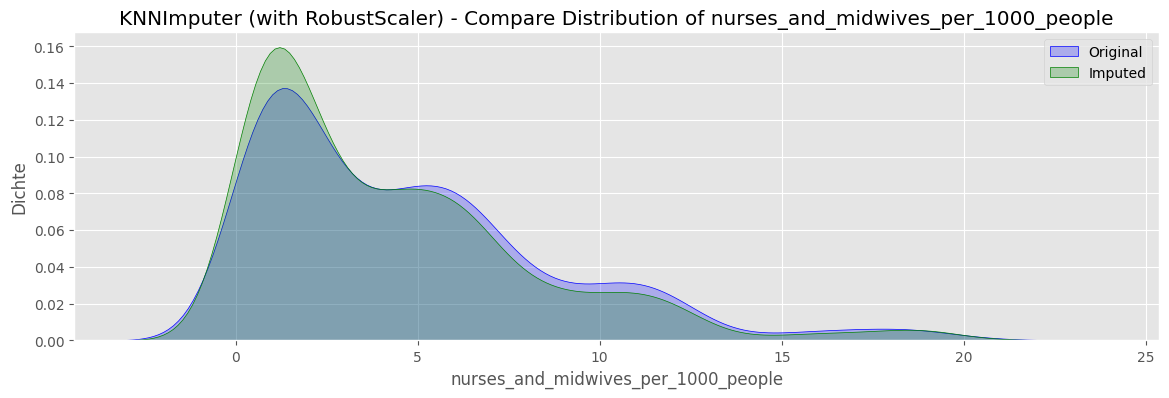

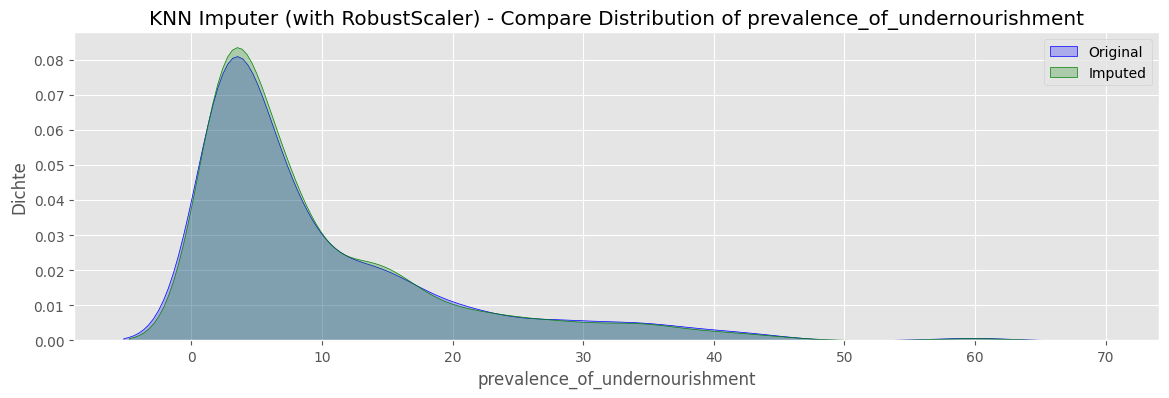

In [75]:
kde_plot_comparison(df_imp_test, knn_df, "physicians_per_1000_people", "KNNImputer (with RobustScaler)")
kde_plot_comparison(df_imp_test, knn_df, "nurses_and_midwives_per_1000_people", "KNNImputer (with RobustScaler)")
kde_plot_comparison(df_imp_test, knn_df, "prevalence_of_undernourishment", "KNN Imputer (with RobustScaler)")

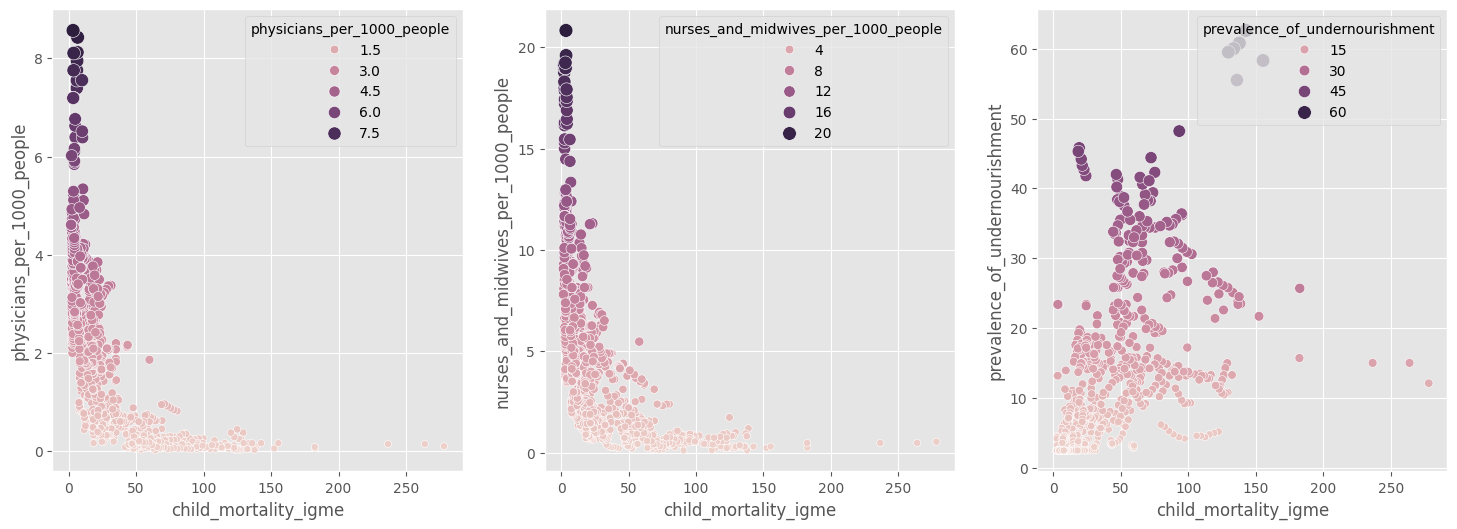

In [80]:
data_exploration.scatterplots(knn_df, most_critical_cols, 3)

In [21]:
#from sklearn.model_selection import GroupShuffleSplit

#gss = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=99)
#for id_train, id_test in gss.split(df_imp_test, groups=df_imp_test["Code"]):
#    train_df = df_imp_test.iloc[id_train]
#    test_df = df_imp_test.iloc[id_test]
#train_df = train_df.drop(columns=["Code"])

#### Test with IterativeImputer

In [68]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

rf_estim = ExtraTreesRegressor(n_estimators=300, max_depth=10, n_jobs=-1, random_state=99)

single_imputer = IterativeImputer(
    estimator=rf_estim,
    max_iter=5,  
    random_state=99,
    initial_strategy='median' 
)

df_imputed_array = single_imputer.fit_transform(df_imp_test.values)


df_imputed = pd.DataFrame(df_imputed_array, columns=df_imp_test.columns, index=df_imp_test.index)
removed_cols = df_for_imp[["Code", "Year", "Entity", "child_mortality_igme"]]
df_final = df_imputed.join(removed_cols)

/Users/hamzahfayad/myportfolio/master_thesis_child_mortality/masterthesis_venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


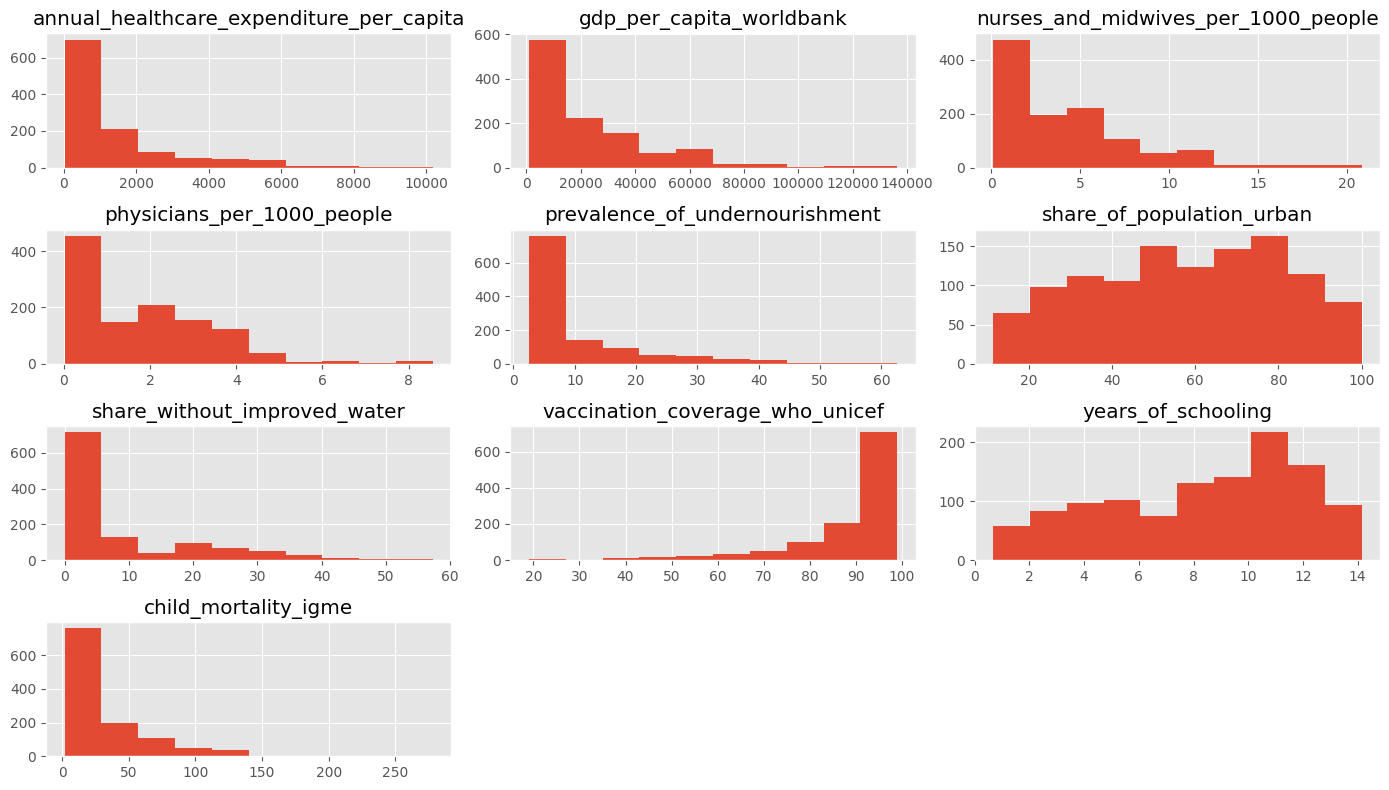

In [95]:
#imputed df histograms
df_f = df_final.drop(columns=["annual_healthcare_expenditure_per_capita_missing", "gdp_per_capita_worldbank_missing", "nurses_and_midwives_per_1000_people_missing", "physicians_per_1000_people_missing","prevalence_of_undernourishment_missing", "share_without_improved_water_missing", "vaccination_coverage_who_unicef_missing", "years_of_schooling_missing", "East Asia and Pacific (WB)", "Europe and Central Asia (WB)", "Latin America and Caribbean (WB)", "Middle East, North Africa, Afghanistan and Pakistan (WB)", "North America (WB)", "North America (WB)","South Asia (WB)","Sub-Saharan Africa (WB)", "Year"])
df_f.hist(figsize=(14,8))
plt.tight_layout()
plt.show()

### Test Imputation by NaNs masking

In [124]:
## how to validate if imputation makes good results
# 0. create copy of main df (which includes the 9 features & region OHE)
# 1. get only 9 main numeric columns (not the missing indicators or the region OHE columns)
# 2. mask (eg. 10% randomly NaNs) to only rows that are 100% complete from step 1 # --> save original complete
# ==> original_complete_mask = df_original.notna().all(axis=1)
# join with rows that have nans, and create new missing indicators (cause i added artificial nans)
# impute
# ==> df_imputed = ....
# compare original with imputed
# ==> df_imputed_subset = df_imputed[original_complete_mask]

In [123]:
len(df_for_imp.dropna())

627

In [131]:
original_complete_mask = df_for_imp.notna().all(axis=1)
original_complete_mask

0       True
1       True
2       True
3       True
4       True
        ... 
1153    True
1154    True
1155    True
1156    True
1157    True
Length: 1158, dtype: bool

In [132]:
df_imputed_subset = df_f[original_complete_mask]
df_imputed_subset

,annual_healthcare_expenditure_per_capita,gdp_per_capita_worldbank,nurses_and_midwives_per_1000_people,physicians_per_1000_people,prevalence_of_undernourishment,share_of_population_urban,share_without_improved_water,vaccination_coverage_who_unicef,years_of_schooling,Code,Entity,child_mortality_igme
0,177.62009,3046.5798,0.255,0.291,19.4,24.373,38.863914,64.0,0.672197,AFG,Afghanistan,78.022990
1,201.79086,3017.9426,0.151,0.304,19.3,24.587,36.337383,62.0,0.710609,AFG,Afghanistan,75.123625
2,215.22618,2967.6921,0.133,0.291,20.0,24.803,33.812515,64.0,0.749020,AFG,Afghanistan,72.438707
3,238.74481,2958.7854,0.151,0.284,20.5,25.020,31.289620,66.0,1.009183,AFG,Afghanistan,69.970040
4,264.20660,2952.9990,0.179,0.245,21.4,25.250,28.765442,64.0,1.269347,AFG,Afghanistan,67.637370
...,...,...,...,...,...,...,...,...,...,...,...,...
1153,203.30057,3352.3813,1.507,0.122,30.4,32.504,22.451942,91.0,7.490000,ZWE,Zimbabwe,61.771426
1154,191.68187,3366.6338,1.349,0.177,33.0,32.385,22.588303,87.0,7.702070,ZWE,Zimbabwe,59.763910
1155,194.29993,3345.3150,1.359,0.174,35.5,32.296,22.715965,90.0,7.881035,ZWE,Zimbabwe,56.912365
1156,143.32605,3453.5059,2.507,0.179,36.7,32.237,22.834778,89.0,8.060000,ZWE,Zimbabwe,54.953800
